# **CS 7641 Homework 1 - Supervised Learning**

### Name: Tianyu Yang
### GTid: 903645962
### Date: 2020/9/20

In this project, I will use two datasets to analyze two interesting classification problems I will use five classification algorithms I learning in this Machine Learning courses, including Decision Tree, Neural Network, Boosting, SVM, and KNN.

In [1]:
# Importing useful packages
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Machine Learning package named sklearn
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as kNN

import itertools
import timeit

## Loading and cleaning datasets

Data are downloaded from Kaggle:<br>
nba games https://www.kaggle.com/nathanlauga/nba-games<br>
lol games https://www.kaggle.com/datasnaek/league-of-legends?select=games.csv<br><br>
nba_games.csv : All games from 2004 season to last update with the date, teams and some details like number of points, etc.<br>
lol_games.csv : This is a collection of over 50,000 ranked EUW games from the game League of Legends, as well as json files containing a way to convert between champion and summoner spell IDs and their names.

In [2]:
# Change the path into your current working directory
os.chdir(r"C:\Users\13102\Desktop\Supervised Learning")

nba_games = pd.read_csv('nba_games.csv')
lol_games = pd.read_csv('lol_games.csv')

### 1. NBA matches data

We will calculate the different between home team and away team in five aspects, including FG_PCT(field goals percentage), FT_PCT(field throws percentage), FG3_PCT(three-point field goals percentage),AST(assists) and REB(rebounds). HOME_TEAM_WINS represents that if home team wins, the value is 1 and if home team loses, the value is 0.

In [3]:
data1 = nba_games[['GAME_DATE_EST','HOME_TEAM_WINS',]]
pd.options.mode.chained_assignment = None

# Select the data for 2019-2020 season from 2019-10-4 to 2020-3-1
start_date='2019-10-4'
end_date='2020-3-1'

data1['GAME_DATE_EST'] = pd.to_datetime(data1['GAME_DATE_EST'])  
mask = (data1['GAME_DATE_EST'] >= start_date) & (data1['GAME_DATE_EST'] <= end_date)
data1 = data1.loc[mask]

# Drop useless columns
data1 = data1.reset_index().drop(columns=['index', 'GAME_DATE_EST'])

cols1 = ['FG_PCT','FT_PCT','FG3_PCT','AST','REB']
for col in cols1:
    data1[col+'_diff'] = nba_games[col+'_home'].sub(nba_games[col+'_away'], axis = 0)

# Change datatype from float32 into int64
X1 = np.array(data1.values[:,1:-1],dtype='int64')
Y1 = np.array(data1.values[:,0],dtype='int64')
data1.describe(include='all')

,HOME_TEAM_WINS,FG_PCT_diff,FT_PCT_diff,FG3_PCT_diff,AST_diff,REB_diff
count,965.00000,965.000000,965.000000,965.000000,965.000000,965.000000
mean,0.54715,0.011031,0.001882,0.005033,1.174093,0.839378
std,0.49803,0.078655,0.146005,0.131647,6.439211,9.418250
min,0.00000,-0.208000,-0.571000,-0.427000,-22.000000,-39.000000
25%,0.00000,-0.043000,-0.092000,-0.086000,-3.000000,-5.000000
50%,1.00000,0.009000,0.000000,0.003000,1.000000,1.000000
75%,1.00000,0.068000,0.094000,0.098000,5.000000,7.000000
max,1.00000,0.258000,0.571000,0.458000,23.000000,31.000000


### 2. LOL games data

We will analyze the lol matches data There are two teams called 1 and 2. From six aspects including first blood, first tower, first inhibitor, first Baron, first Dragon, first RiftHerald to analyze the winner of each game.

In [4]:
data2 = lol_games[['winner','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald']]
# We only used 965 data for testing which is the same as data1
data2 = data2.head(965)
X2 = data2.values[:,1:-1]
Y2 = data2.values[:,0]
data2.describe(include='all')

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
count,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000
mean,1.491192,1.469430,1.443523,1.304663,0.890155,1.441451,0.757513
std,0.500182,0.511637,0.544848,0.663535,0.832656,0.572486,0.821936
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


## Useful functions

### 1. Machine Learning Algorithms functions

In [5]:
# Decision Tree
def hyperTree(X_train, y_train, X_test, y_test, title):    
    f1_test = []; f1_train = []
    # Max depth of tree is 20
    max_depth = list(range(1,20))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
            
    plot(max_depth,f1_train,f1_test,"Max Depth of Tree","F1 Score","train","test",title)
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    # We search from 15 values from the selected training data
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,15).round().astype('int'), 'max_depth':np.arange(1,15)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Best parameters of DT model: ")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

In [6]:
# Neural Networks
def hyperNN(X_train, y_train, X_test, y_test, title):
    f1_test = []; f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', learning_rate_init=0.05, 
                                max_iter=1000, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
    
    plot(hlist,f1_train,f1_test,"No. Hidden Units","F1 Score","train","test",title)
    
    
def NNGridSearchCV(X_train, y_train):
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',max_iter=1000, random_state=100),
                       param_grid=param_grid, cv=10, scoring='accuracy')
    net.fit(X_train, y_train)
    print("Best parameters of SVM model: ")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

In [7]:
# Boosting Tree
def hyperBoost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):    
    f1_test = []; f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), min_samples_leaf=int(min_samples_leaf/2), 
                                             random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
    
    plot(n_estimators,f1_train,f1_test,"No. Estimators","F1 Score","train","test",title)

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
                  'max_depth': np.arange(1,4),
                  'n_estimators': np.linspace(10,100,3).round().astype('int'),
                  'learning_rate': np.linspace(.001,.1,3)}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Best parameters of Boosting Tree model: ")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

In [8]:
# SVM
def hyperSVM(X_train, y_train, X_test, y_test, title):
    f1_test = []; f1_train = []
    # We will use four different kernals of SVM and compare with the result
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:
        clf = SVC(kernel=i, random_state=100)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plot(kernel_func,f1_train,f1_test,"Kernels","F1 Score","train","test",title)
    
def SVMGridSearchCV(X_train, y_train):
    Cs = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gammas = [1,10,100]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = SVC(kernel='rbf',random_state=100), param_grid=param_grid, cv=10)
    clf.fit(X_train, y_train)
    print("Best parameters of SVM model: ")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

In [9]:
# KNN
def hyperKNN(X_train, y_train, X_test, y_test, title):    
    f1_test = []; f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))

    plot(klist,f1_train,f1_test,"No. Neighbors","F1 Score","train","test",title)

### 1. Ploting functions

In [10]:
def plotTraining(clf, X, y, title):    
    n = len(y)
    train_mean = []; train_std = []; cv_mean = []; cv_std = []; fit_mean = []; fit_std = []; pred_mean = []; pred_std = []
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot(train_sizes,train_mean,cv_mean,"Training Examples","F1 Score","Training Score","Cross-Validation Score","Training: "+title)
    plot(train_sizes,fit_mean,pred_std,"Training Examples","Training Time (s)","Training Time (s)","Prediction Time (s)",
         "Modeling Time: "+title)
    
    return train_sizes, train_mean, fit_mean, pred_mean      
    
def plotConfusionMatrix(cm):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0","1"])
    plt.yticks(tick_marks, ["0","1"])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
def evaluation(clf,X_train, X_test, y_train, y_test):
    # Timer for training and predicting time
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    cm = confusion_matrix(y_test,y_pred)
    plotConfusionMatrix(cm)
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    
    print("Training Time (s):   "+"{:.5f}".format(training_time))
    print("Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("AUC:  "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision))
    print("Recall: "+"{:.2f}".format(recall))
    
def plot(x, y1, y2, label_x, label_y, label_y1, label_y2, title):
    plt.figure()
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.plot(x, y1, 'o-', label=label_y1)
    plt.plot(x, y2, 'o-', label=label_y2)
    plt.legend(loc="best")
    plt.show()  

def plotCompGraph(sample, DT, NN, B, SVM, kNN, title, graph_title):
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel(graph_title)
    plt.plot(sample, DT, label="Decision Tree")
    plt.plot(sample, NN, label="Neural Network")
    plt.plot(sample, B, label="Boosting")
    plt.plot(sample, SVM, label="SVM")
    plt.plot(sample, kNN, label="kNN")
    plt.legend(loc="best")
    plt.show()

## Running Machine Learning models

### 1. Decision Tree

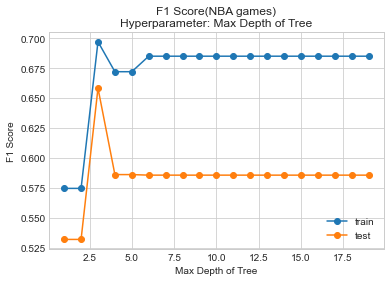

Best parameters of DT model: 
{'max_depth': 3, 'min_samples_leaf': 8}


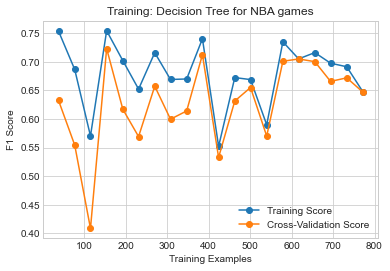

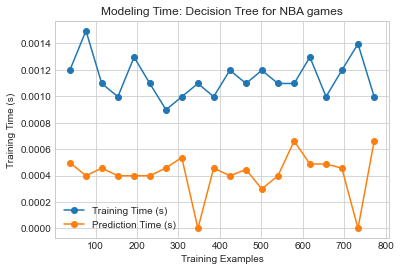

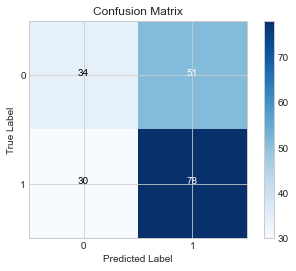

Training Time (s):   0.00122
Prediction Time (s): 0.00011

F1 Score:  0.66
Accuracy:  0.58
AUC:  0.56
Precision: 0.60
Recall: 0.72


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.20)
hyperTree(X_train, y_train, X_test, y_test,title="F1 Score(NBA games)\nHyperparameter: Max Depth of Tree")
# 1% to 5% of leaf nodes are tested
start_leaf_n = round(0.01*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)

estimator_nba = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
samp_nba, DT_train_score_nba, DT_train_time_nba, DT_pred_time_nba = plotTraining(estimator_nba, X_train, y_train,
                                                                                 title="Decision Tree for NBA games")
evaluation(estimator_nba, X_train, X_test, y_train, y_test)

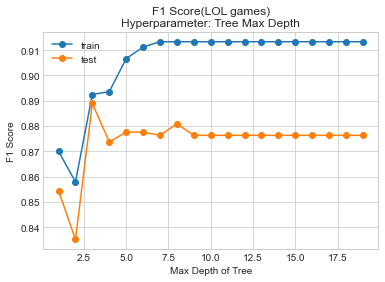

Best parameters of DT model: 
{'max_depth': 7, 'min_samples_leaf': 15}


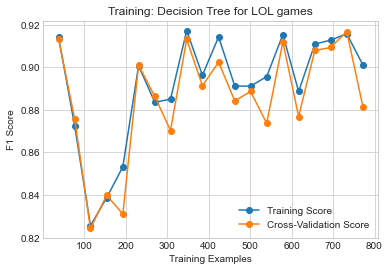

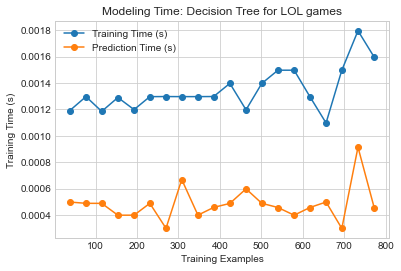

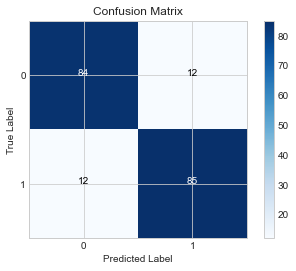

Training Time (s):   0.00094
Prediction Time (s): 0.00015

F1 Score:  0.88
Accuracy:  0.88
AUC:  0.88
Precision: 0.88
Recall: 0.88


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size=0.20)
hyperTree(X_train, y_train, X_test, y_test,title="F1 Score(LOL games)\nHyperparameter: Tree Max Depth")
# 1% to 5% of leaf nodes are tested
start_leaf_n = round(0.01*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)

estimator_lol = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
samp_lol, DT_train_score_lol, DT_train_time_lol, DT_pred_time_lol = plotTraining(estimator_lol, X_train, y_train,
                                                                                 title="Decision Tree for LOL games")
evaluation(estimator_lol, X_train, X_test, y_train, y_test)

### 2. Neural Networks

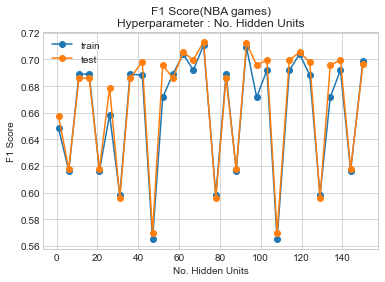

Best parameters of SVM model: 
{'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}


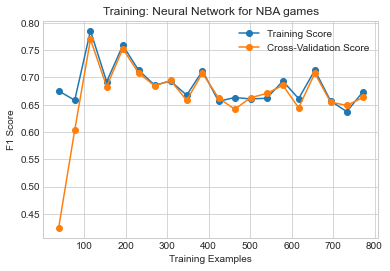

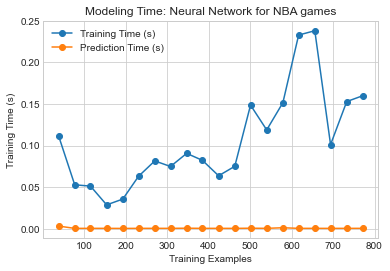

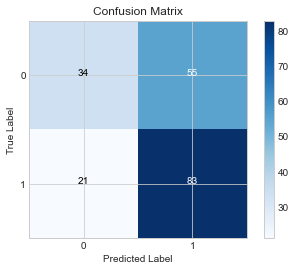

Training Time (s):   0.15388
Prediction Time (s): 0.00071

F1 Score:  0.69
Accuracy:  0.61
AUC:  0.59
Precision: 0.60
Recall: 0.80


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.20)
hyperNN(X_train, y_train, X_test, y_test,title="F1 Score(NBA games)\nHyperparameter : No. Hidden Units")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)

estimator_nba = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', learning_rate_init=learn_rate, 
                              random_state=100)
samp_nba, NN_train_score_nba, NN_train_time_nba, NN_pred_time_nba = plotTraining(estimator_nba, X_train, y_train,
                                                                                 title="Neural Network for NBA games")
evaluation(estimator_nba, X_train, X_test, y_train, y_test)

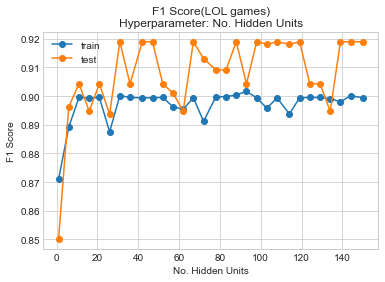

Best parameters of SVM model: 
{'hidden_layer_sizes': 30, 'learning_rate_init': 0.1}


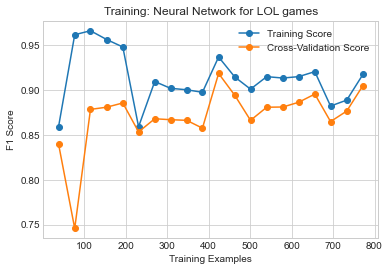

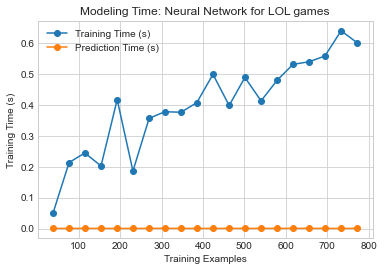

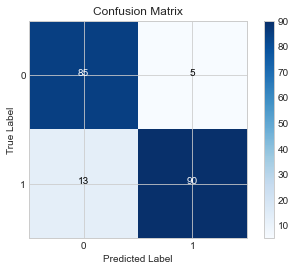

Training Time (s):   0.49604
Prediction Time (s): 0.00031

F1 Score:  0.90
Accuracy:  0.91
AUC:  0.91
Precision: 0.87
Recall: 0.94


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size=0.20)
hyperNN(X_train, y_train, X_test, y_test,title="F1 Score(LOL games)\nHyperparameter: No. Hidden Units")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)

estimator_lol = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', learning_rate_init=learn_rate,
                              max_iter=1000, random_state=0)
samp_lol, NN_train_score_lol, NN_train_time_lol, NN_pred_time_lol = plotTraining(estimator_lol, X_train, y_train,
                                                                                 title="Neural Network for LOL games")
evaluation(estimator_lol, X_train, X_test, y_train, y_test)

### 3. Boosting

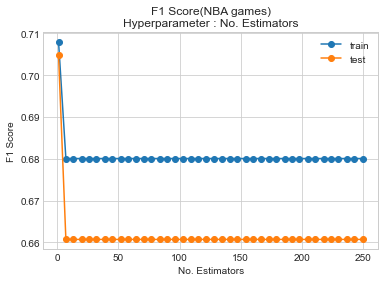

Best parameters of Boosting Tree model: 
{'learning_rate': 0.0505, 'max_depth': 1, 'min_samples_leaf': 8, 'n_estimators': 100}


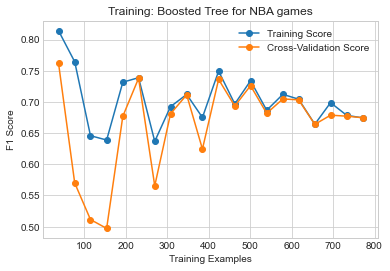

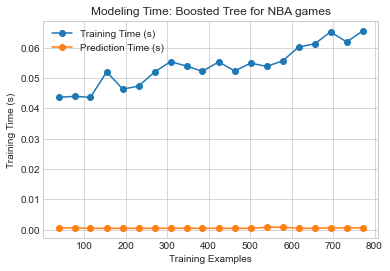

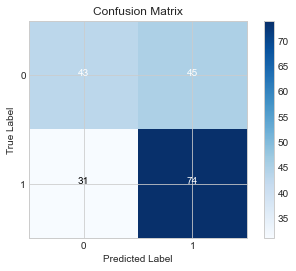

Training Time (s):   0.04558
Prediction Time (s): 0.00048

F1 Score:  0.66
Accuracy:  0.61
AUC:  0.60
Precision: 0.62
Recall: 0.70


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.20)
hyperBoost(X_train, y_train, X_test, y_test, 3, 50, title="F1 Score(NBA games)\nHyperparameter : No. Estimators")
# 1% to 5% of leaf nodes are tested
start_leaf_n = round(0.01*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf, n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)

estimator_nba = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,n_estimators=n_est, 
                                           learning_rate=learn_rate, random_state=100)
samp_nba, BT_train_score_nba, BT_train_time_nba, BT_pred_time_nba = plotTraining(estimator_nba, X_train, y_train,
                                                                                 title="Boosted Tree for NBA games")
evaluation(estimator_nba, X_train, X_test, y_train, y_test)

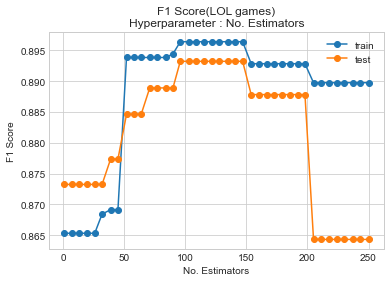

Best parameters of Boosting Tree model: 
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 8, 'n_estimators': 100}


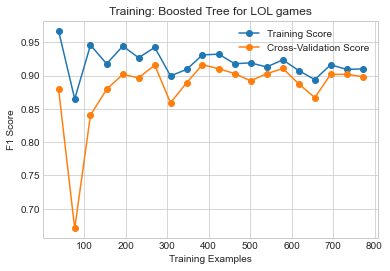

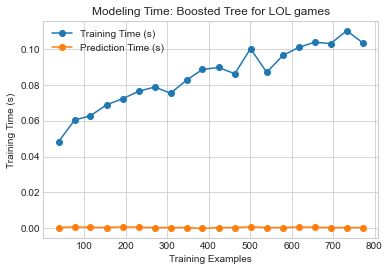

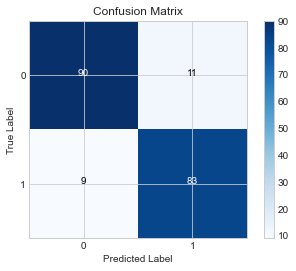

Training Time (s):   0.07427
Prediction Time (s): 0.00104

F1 Score:  0.90
Accuracy:  0.90
AUC:  0.90
Precision: 0.91
Recall: 0.89


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size=0.20)
hyperBoost(X_train, y_train, X_test, y_test, 3, 50, title="F1 Score(LOL games)\nHyperparameter : No. Estimators")
# 1% to 5% of leaf nodes are tested
start_leaf_n = round(0.01*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf, n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)

estimator_lol = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_est, 
                                           learning_rate=learn_rate, random_state=100)
samp_lol, BT_train_score_lol, BT_train_time_lol, BT_pred_time_lol = plotTraining(estimator_lol, X_train, y_train,
                                                                                 title="Boosted Tree for LOL games")
evaluation(estimator_lol, X_train, X_test, y_train, y_test)

### 4. SVM

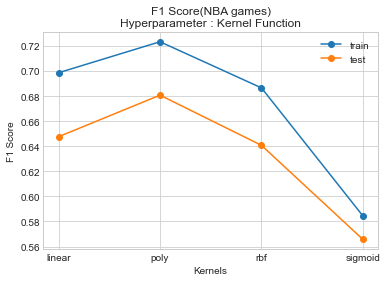

Best parameters of SVM model: 
{'C': 10.0, 'gamma': 1}


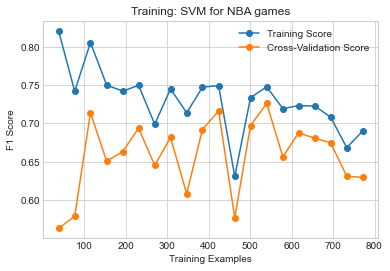

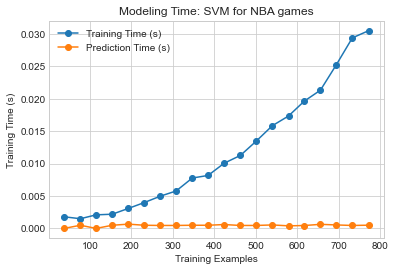

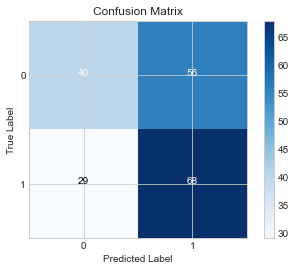

Training Time (s):   0.03191
Prediction Time (s): 0.00251

F1 Score:  0.62
Accuracy:  0.56
AUC:  0.56
Precision: 0.55
Recall: 0.70


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.20)
hyperSVM(X_train, y_train, X_test, y_test,title="F1 Score(NBA games)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)

estimator_nba = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
samp_nba, SVM_train_score_nba, SVM_train_time_nba, SVM_pred_time_nba = plotTraining(estimator_nba, X_train, y_train,
                                                                                    title="SVM for NBA games")
evaluation(estimator_nba, X_train, X_test, y_train, y_test)

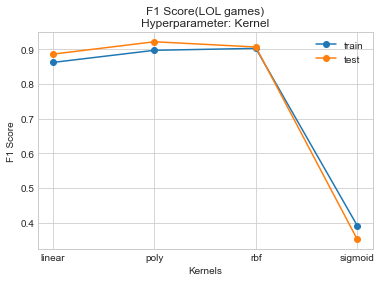

Best parameters of SVM model: 
{'C': 1, 'gamma': 1}


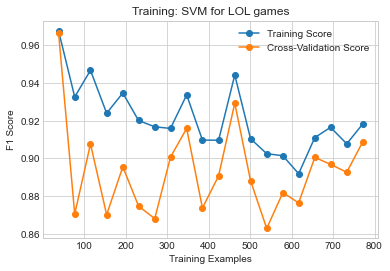

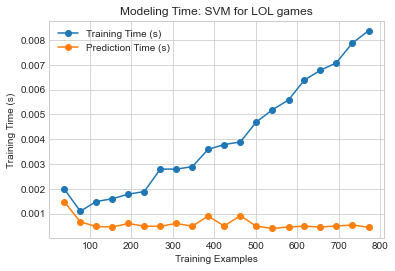

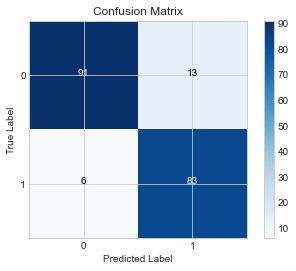

Training Time (s):   0.00677
Prediction Time (s): 0.00108

F1 Score:  0.91
Accuracy:  0.90
AUC:  0.90
Precision: 0.94
Recall: 0.88


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size=0.20)
hyperSVM(X_train, y_train, X_test, y_test,title="F1 Score(LOL games)\nHyperparameter: Kernel")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)

estimator_lol = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
samp_lol, SVM_train_score_lol, SVM_train_time_lol, SVM_pred_time_lol = plotTraining(estimator_lol, X_train, y_train,
                                                                                    title="SVM for LOL games")
evaluation(estimator_lol, X_train, X_test, y_train, y_test)

### 5. KNN

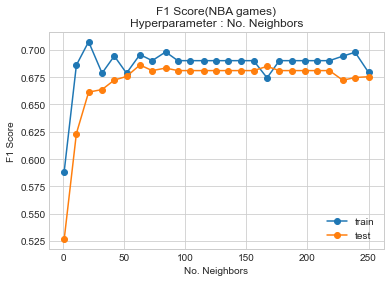

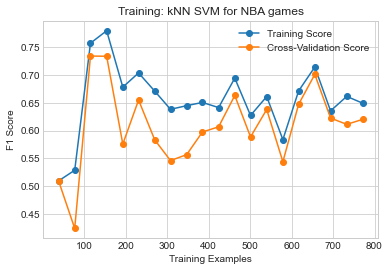

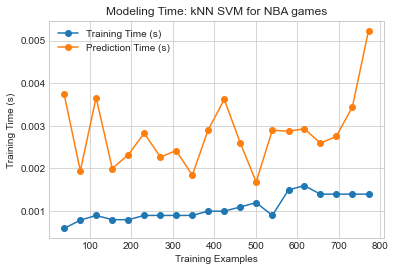

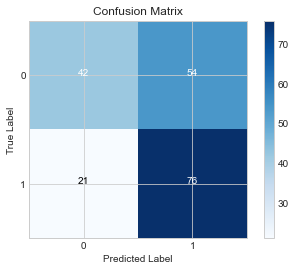

Training Time (s):   0.00115
Prediction Time (s): 0.01430

F1 Score:  0.67
Accuracy:  0.61
AUC:  0.61
Precision: 0.58
Recall: 0.78


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size=0.20)
hyperKNN(X_train, y_train, X_test, y_test,title="F1 Score(NBA games)\nHyperparameter : No. Neighbors")
estimator_nba = kNN(n_neighbors=20, n_jobs=-1)
samp_nba, kNN_train_score_nba, kNN_train_time_nba, kNN_pred_time_nba = plotTraining(estimator_nba, X_train, y_train,
                                                                                    title="kNN SVM for NBA games")
evaluation(estimator_nba, X_train, X_test, y_train, y_test)

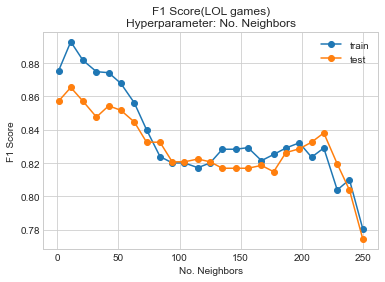

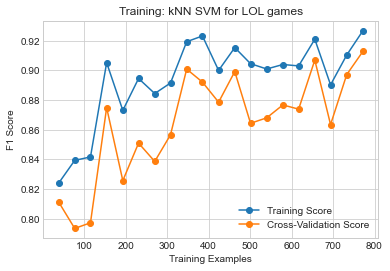

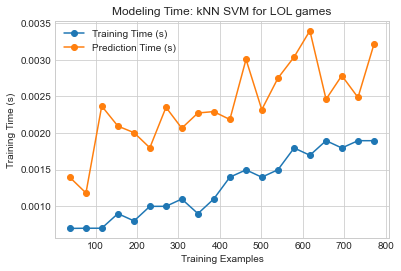

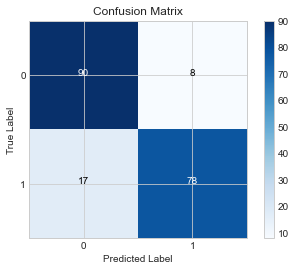

Training Time (s):   0.00163
Prediction Time (s): 0.01618

F1 Score:  0.88
Accuracy:  0.87
AUC:  0.87
Precision: 0.84
Recall: 0.92


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size=0.20)
hyperKNN(X_train, y_train, X_test, y_test,title="F1 Score(LOL games)\nHyperparameter: No. Neighbors")
estimator_lol = kNN(n_neighbors=5, n_jobs=-1)
samp_lol, kNN_train_score_lol, kNN_train_time_lol, kNN_pred_time_lol = plotTraining(estimator_lol, X_train, y_train,
                                                                                    title="kNN SVM for LOL games")
evaluation(estimator_lol, X_train, X_test, y_train, y_test)

## Comparing with five supervised learning algorithms

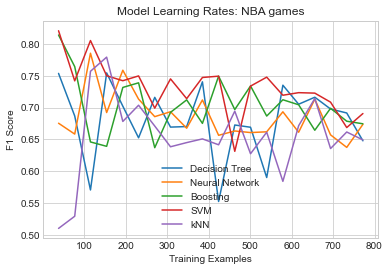

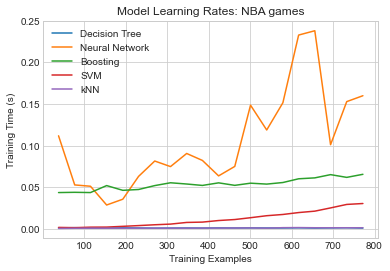

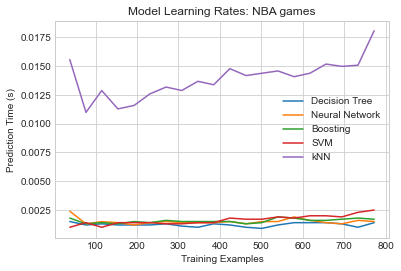

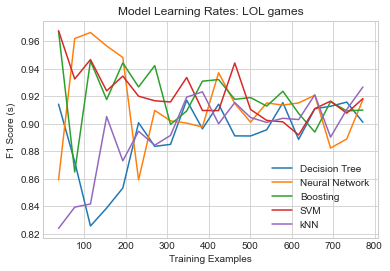

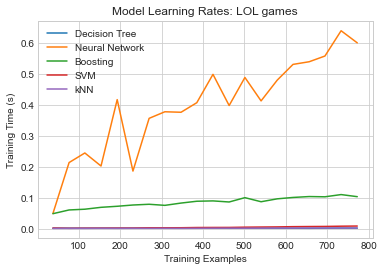

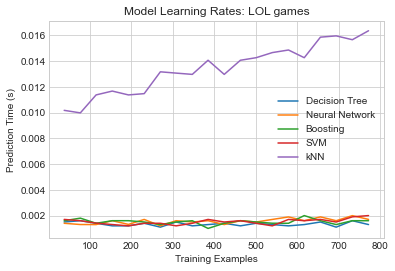

In [21]:
# NBA games
plotCompGraph(samp_nba, DT_train_score_nba, NN_train_score_nba, BT_train_score_nba, SVM_train_score_nba, kNN_train_score_nba, 
              'NBA games', 'F1 Score')
plotCompGraph(samp_nba, DT_train_time_nba, NN_train_time_nba, BT_train_time_nba, SVM_train_time_nba, kNN_train_time_nba, 
              'NBA games', 'Training Time (s)')
plotCompGraph(samp_nba, DT_pred_time_nba, NN_pred_time_nba, BT_pred_time_nba, SVM_pred_time_nba, kNN_pred_time_nba, 
              'NBA games', 'Prediction Time (s)')

# LOL games
plotCompGraph(samp_lol, DT_train_score_lol, NN_train_score_lol, BT_train_score_lol, SVM_train_score_lol, kNN_train_score_lol, 
              'LOL games', 'F1 Score (s)')
plotCompGraph(samp_nba, DT_train_time_lol, NN_train_time_lol, BT_train_time_lol, SVM_train_time_lol, kNN_train_time_lol, 
              'LOL games', 'Training Time (s)')
plotCompGraph(samp_nba, DT_pred_time_lol, NN_pred_time_lol, BT_pred_time_lol, SVM_pred_time_lol, kNN_pred_time_lol, 
              'LOL games', 'Prediction Time (s)')